### Problem 2:

In [17]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import pprint

In [18]:
class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self, feature_maps):
        super(Classifier, self).__init__()
        self.feature_maps = feature_maps
        layers = self.layer(1,feature_maps[0])+self.layer(feature_maps[0],feature_maps[1])+self.layer(feature_maps[1],feature_maps[2])+self.layer(feature_maps[2],feature_maps[3])+self.layer(feature_maps[3],feature_maps[4])
        self.conv = nn.Sequential(*layers)
        self.clf = nn.Linear(feature_maps[-1], 10)        
        
    def layer(self, i, o):
        return [nn.Conv2d(in_channels=i, out_channels=o, kernel_size=(4, 4), padding=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2), stride=2)]
    
    def num_parameters(self):
        pars = 0
        for a,b in zip([1] + self.feature_maps, self.feature_maps):
            current_layer_parameters = a * 16 * b
            pars = pars + current_layer_parameters
        pars = pars + self.feature_maps[-1] * 10
        print("we have ", float(pars)/1000000, " million parameters") # Ignore biases
    
    def forward(self, x):
        x = self.conv(x)
        y = x.squeeze()
        return self.clf(y)

In [24]:
perf = {}

torch.manual_seed(0)
mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transforms, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=mnist_transforms, download=True)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=2)

cuda_available = torch.cuda.is_available()
print("Cuda available: %s" % cuda_available)
feature_maps = [[20,40,60,80,128]] #, [20,40,60,50,40], [20,40,50,60,70]]

for feature_map in feature_maps:
    hyper = str(feature_map)
    print(hyper)
    perf[hyper] = []
    clf = Classifier(feature_map)
    clf.num_parameters()
    if cuda_available:
        clf = clf.cuda()
    optimizer = torch.optim.SGD(clf.parameters(), lr=0.1)
    criterion = nn.CrossEntropyLoss() #  LogSoftmax and NLLLoss

    for epoch in range(10):
        # Train
        current_epoch_loss = []
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            if cuda_available:
                inputs, targets = inputs.cuda(), targets.cuda()

            optimizer.zero_grad()
            loss = criterion(clf(inputs), targets)
            loss.backward()
            optimizer.step()
            current_epoch_loss.append(loss.item())
            
            if batch_idx%30==0:
                print('Epoch : %d, Loss : %.3f ' % (epoch, np.mean(current_epoch_loss)))
        myLoss =  np.mean(current_epoch_loss)

       

        # Evaluate
        clf.eval()
        total = 0
        correct = 0
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            if cuda_available:
                inputs, targets = inputs.cuda(), targets.cuda()
            outputs = clf(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()
        accur = 100*float(correct)/total    
        #print('Epoch : %d, Test Accuracy : %.2f%%, number of tests : %d' % (epoch, accur, total))
        #print('--------------------------------------------------------------')
        clf.train()
        perf[hyper].append((accur, myLoss))
    print(perf[hyper])


        
 


Cuda available: False
[20, 40, 60, 80, 128]
we have  0.29344  million parameters
Epoch : 0, Loss : 2.300 
Epoch : 0, Loss : 2.304 
Epoch : 0, Loss : 2.303 
Epoch : 0, Loss : 2.302 
Epoch : 0, Loss : 2.301 
Epoch : 0, Loss : 2.300 
Epoch : 0, Loss : 2.300 
Epoch : 0, Loss : 2.299 
Epoch : 0, Loss : 2.298 
Epoch : 0, Loss : 2.296 
Epoch : 0, Loss : 2.291 
Epoch : 0, Loss : 2.277 
Epoch : 0, Loss : 2.246 
Epoch : 0, Loss : 2.171 
Epoch : 0, Loss : 2.072 
Epoch : 0, Loss : 1.975 
Epoch : 0, Loss : 1.880 
Epoch : 0, Loss : 1.790 
Epoch : 0, Loss : 1.707 
Epoch : 0, Loss : 1.631 
Epoch : 0, Loss : 1.561 
Epoch : 0, Loss : 1.497 
Epoch : 0, Loss : 1.437 
Epoch : 0, Loss : 1.382 
Epoch : 0, Loss : 1.332 
Epoch : 0, Loss : 1.284 
Epoch : 0, Loss : 1.240 
Epoch : 0, Loss : 1.199 
Epoch : 0, Loss : 1.161 
Epoch : 0, Loss : 1.125 
Epoch : 0, Loss : 1.092 
Epoch : 0, Loss : 1.061 
Epoch : 1, Loss : 0.092 
Epoch : 1, Loss : 0.120 
Epoch : 1, Loss : 0.124 
Epoch : 1, Loss : 0.115 
Epoch : 1, Loss : 0

We plot the training error and validation accuracy for the ten epochs. The training error for each epoch indicates the mean of all the losses at each step during that epoch. 

In [25]:
best_performance = max(perf.values(), key=lambda x: max([a[0] for a in x]))
best_accuracy = [x[0] for x in best_performance]
best_loss = [x[1] for x in best_performance]


In [26]:
def plotThis(x, label ):
    xnew = np.linspace(np.arange(x.shape[0]).min(),np.arange(x.shape[0]).max(),300)
    spl = make_interp_spline(np.arange(x.shape[0]),x, k=3)
    power_smooth = spl(xnew)
    xx = plt.plot(xnew,power_smooth, label = label)


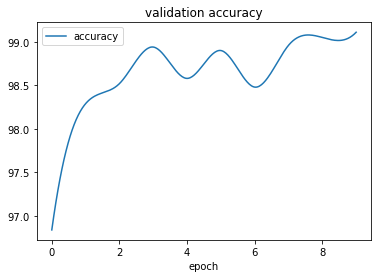

In [27]:
plotThis(np.array(best_accuracy), "accuracy")

plt.title("validation accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

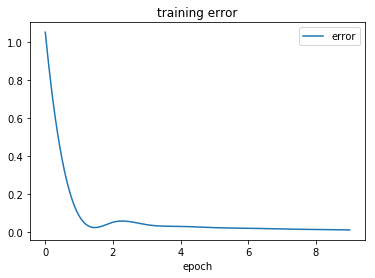

In [28]:
plotThis(np.array(best_loss), "error")

plt.title("training error")
plt.legend()
plt.xlabel("epoch")
plt.show()

We also tried with dropout between p=0.1 or p=0.4 for various convolutional layers. This was inspired by Park et.al (Analysis on the Dropout Effect in Convolutional Neural Networks), slightly improved generalization. The dropout rate the first layer had been set to 0 for the same reason.
We also compared the dropout results with batch normalization, and found no improvements with batch normalization.